In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/My Drive/"

In [ ]:
# !git clone https://github.com/TheFoodForest/Plant-Pathology-Kaggle.git


In [ ]:
%cd "Plant-Pathology-Kaggle"

In [ ]:
%ls

In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import cv2
from tqdm import tqdm


import matplotlib.pyplot as plt


import os 
import glob

tqdm.pandas()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
labels = pd.read_csv('train.csv')

In [3]:
display(labels.head())
labels.info()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [4]:

# image to array function 
def load_image(image_id):
    image = cv2.imread(image_id)
    return np.float64(image)


def create_paths(img):
    return 'images/{}.jpg'.format(img)


labels['path'] = labels.image_id.progress_apply(create_paths)

100%|█████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 1017698.55it/s]


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [6]:
X = labels.loc[:,'path']
y = labels.loc[:, labels.columns[1:5]]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=13,stratify=y,test_size=0.25)

# zippedtrain = zip(X_train,y_train)
# zippedtest = zip(X_test,y_test)
# train_df = pd.DataFrame({'path':X_train,'class':[list(i) for i in y_train]})
# test_df = pd.DataFrame({'path':X_test,'class':[list(i) for i in y_test]})

train_df = pd.DataFrame(X_train).join(pd.DataFrame(y_train))
test_df = pd.DataFrame(X_test).join(pd.DataFrame(y_test))

train_df.head()

path  healthy  multiple_diseases  rust  scab
1601  images/Train_1601.jpg        1                  0     0     0
1414  images/Train_1414.jpg        1                  0     0     0
1701  images/Train_1701.jpg        0                  0     0     1
516    images/Train_516.jpg        0                  0     1     0
1708  images/Train_1708.jpg        0                  1     0     0

In [7]:
def get_channel_means(path_list):
    blue_means = []
    green_means = []
    red_means = []
    counter = 1
    for path in path_list:
        img = load_image(path)
        blue_mean = img[:,:,0].mean()
        green_mean = img[:,:,1].mean()
        red_mean = img[:,:,2].mean()
        blue_means.append(blue_mean)
        green_means.append(green_mean)
        red_means.append(red_mean)
        if counter % 75 == 0:
            print('{} images calculated!'.format(counter))
        counter += 1
        # means.append([blue_mean, green_mean, red_mean])
    return blue_means, green_means, red_means 

# fit_x = train_df.path.progress_apply(load_image).values

blue_means, green_means, red_means = get_channel_means(train_df.path.values)
blue_mean = (sum(blue_means) / len(blue_means)) * 1./255
green_mean = (sum(green_means) / len(green_means)) * 1./255
red_mean = (sum(red_means) / len(red_means)) * 1./255




75 images calculated!
150 images calculated!
225 images calculated!
300 images calculated!
375 images calculated!
450 images calculated!
525 images calculated!
600 images calculated!
675 images calculated!
750 images calculated!
825 images calculated!
900 images calculated!
975 images calculated!
1050 images calculated!
1125 images calculated!
1200 images calculated!
1275 images calculated!
1350 images calculated!


In [7]:
# means = [red_mean, green_mean, blue_mean]
# means = [0.4043033271154857, 0.4043033271154857, 0.3131933874018047]
# means

red_mean = 0.4043033271154857
green_mean  = 0.5134412407909822
blue_mean = 0.3131933874018047

In [8]:

labels.drop(columns='image_id', inplace=True)
labels = labels[['path', 'healthy','multiple_diseases','rust','scab']]

In [9]:

labels.head()

path  healthy  multiple_diseases  rust  scab
0  images/Train_0.jpg        0                  0     0     1
1  images/Train_1.jpg        0                  1     0     0
2  images/Train_2.jpg        1                  0     0     0
3  images/Train_3.jpg        0                  0     1     0
4  images/Train_4.jpg        1                  0     0     0

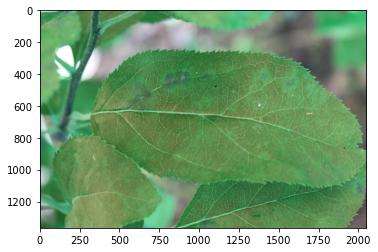

In [11]:

# print(blue_mean)
# print(green_mean)
# print(red_mean)
# def channel_norm(img, label=None):
#     # img = np.array(img)
#     # img[:,:,0] -= blue_mean * (1./255)
#     # img[:,:,1] -= green_mean * (1./255)
#     # img[:,:,2] -= red_mean * (1./255)
#     img = tf.image.per_image_standardization(img)
#     if label is None:
#         return img
#     else:
#       return img, label


def random_blurr(img, label=None):
    go = np.random.randint(0,10)
    if go > 6:
#         num = np.random.randint(10,30)
#         kernel = np.ones((num,num),'float')*( 1.0 / (num*num) )
#         img = cv2.filter2D(img,-1,kernel)
        num = np.random.randint(5,12)
        img = cv2.blur(img, (num,num))
    if label is None:
        return img
    else:
        return img, label
   


img = random_blurr(cv2.imread(train_df.path[1800]))
plt.imshow(img)
# print(img)

In [89]:
 
def decode_image(filename, label=None, image_size=(256,256)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float64)
    image = image * (1.0 / 255)
    means = tf.constant([
        [
            [red_mean, green_mean, blue_mean]
        ]
    ],dtype='float64')
    image = tf.math.subtract(image, means)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label
    




def data_augment(image, label=None):
    image_size=(256,256)
    image, label = decode_image(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image,size=[196,196,3])
    image = tf.image.resize(image, image_size)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    if label is None:
        return image
    else:
        return image, label

In [80]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
import datetime

In [ ]:
# !pip install kaggle_datasets

In [ ]:
# # configure TPU from Colab
# from kaggle_datasets import KaggleDatasets
# AUTO = tf.data.experimental.AUTOTUNE
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [90]:
# def channel_norm(img, label=None):
#   if label is None:
#     return img - means, label
#   else:
#     return img - means, label






X = labels.loc[:,'path']
y = labels.loc[:, labels.columns[1:5]]

train_paths, valid_paths, train_labels, valid_labels = train_test_split(X, y, stratify=y, test_size=0.25, random_state=13)

train_data = (
    tf.data.Dataset
    .from_tensor_slices((train_paths.values, train_labels.values))
#     .map(decode_image, num_parallel_calls=4)
    .map(data_augment, num_parallel_calls=5)
    .repeat()
    .shuffle(512)
    .batch(32)
    .prefetch(256)
)

valid_data = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths.values, valid_labels.values))
    .map(decode_image, num_parallel_calls=5)
    .shuffle(512)
    .cache()
    .repeat()
    .batch(32)
    .prefetch(256)
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)






# def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
#                lr_min=0.00001, lr_rampup_epochs=5, 
#                lr_sustain_epochs=0, lr_exp_decay=.8):
#     lr_max = lr_max * strategy.num_replicas_in_sync

#     def lrfn(epoch):
#         if epoch < lr_rampup_epochs:
#             lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
#         elif epoch < lr_rampup_epochs + lr_sustain_epochs:
#             lr = lr_max
#         else:
#             lr = (lr_max - lr_min) *\
#                  lr_exp_decay**(epoch - lr_rampup_epochs\
#                                 - lr_sustain_epochs) + lr_min
#         return lr
#     return lrfn

stop = tf.keras.callbacks.EarlyStopping(patience=10)

# lrfn = build_lrfn()
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [91]:
a = list(train_data.take(1).as_numpy_iterator())

print(a[0][0][0])



[[[-0.02335031 -0.02579732 -0.02660587]
  [-0.02970754 -0.03215456 -0.0329631 ]
  [-0.03153046 -0.03397748 -0.03478602]
  ...
  [-0.09475043 -0.11959895 -0.13697383]
  [-0.09462789 -0.11716642 -0.1354726 ]
  [-0.09589933 -0.11417723 -0.13420115]]

 [[-0.02716465 -0.02875279 -0.02914876]
  [-0.03517079 -0.03303263 -0.03373987]
  [-0.03841415 -0.03404103 -0.03491702]
  ...
  [-0.09453189 -0.11938041 -0.13675529]
  [-0.09335645 -0.11591869 -0.13688311]
  [-0.09462789 -0.11297323 -0.14055838]]

 [[-0.02923267 -0.03035516 -0.03052744]
  [-0.038978   -0.03391554 -0.03456785]
  [-0.04344972 -0.03494058 -0.03585314]
  ...
  [-0.09452543 -0.11937395 -0.13674882]
  [-0.09308971 -0.11566481 -0.13807045]
  [-0.09393854 -0.11232046 -0.14400508]]

 ...

 [[-0.05216385 -0.11123525 -0.05865346]
  [-0.0490045  -0.10807589 -0.05295124]
  [-0.04511889 -0.10419028 -0.04768694]
  ...
  [ 0.31290752  0.11413967  0.1774207 ]
  [ 0.30941316  0.11786695  0.17188007]
  [ 0.49509144  0.28202453  0.31951246]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


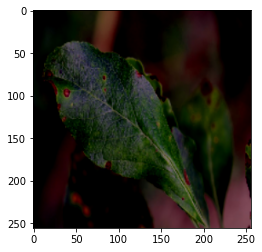

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 1 0]


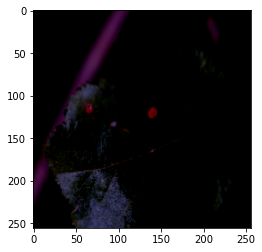

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 1 0]


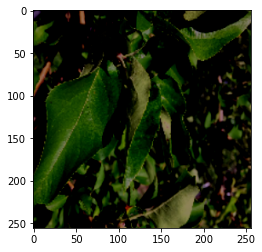

[1 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


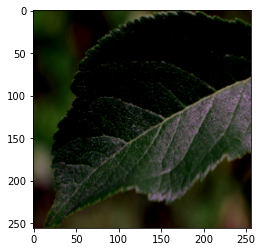

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 0 0 0]


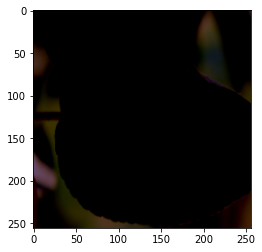

[0 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


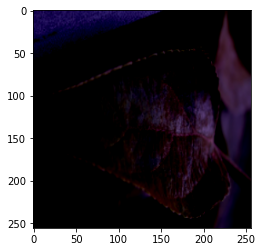

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


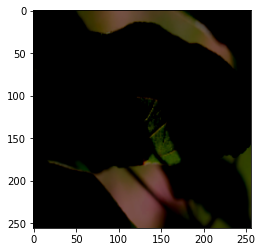

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


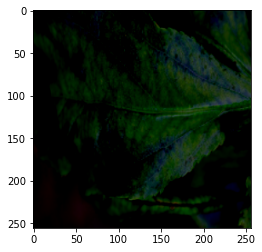

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


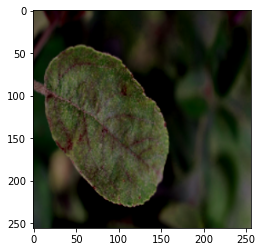

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


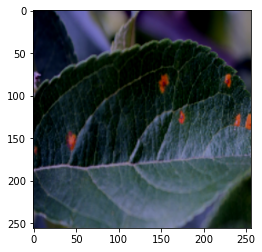

[0 0 1 0]


In [92]:
for i in range(10):
    plt.imshow(a[0][0][i])
    plt.show()
    print(a[0][1][i])

In [27]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 15648), started 0:00:31 ago. (Use '!kill 15648' to kill it.)

In [93]:
#creating new model from experience with previous models - using the above tensor datasets and tensorboard callback to hopefully train faster with more insight 

# model4 = models.Sequential(name='post-conv-activation')
# model4.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation=None, input_shape=(512, 512,3), padding='same',
#                        data_format='channels_last', name='input_conv'))
# model4.add(layers.Conv2D(32, (3,3), activation=None, padding='same', name='input_conv2'))
# model4.add(layers.BatchNormalization(scale=False, name='Norm_group1'))
# model4.add(layers.Activation('relu', name='Activation_group1'))
# model4.add(layers.MaxPooling2D(name='pool_group1'))

# model4.add(layers.Conv2D(64, (3,3), activation=None, padding='same', name='conv1_group2'))
# model4.add(layers.Conv2D(64, (3,3), activation=None, padding='same', name='caonv2_group2'))
# model4.add(layers.BatchNormalization(scale=False, name='Norm_group2'))
# model4.add(layers.Activation('relu', name='actv_group2'))
# model4.add(layers.MaxPooling2D( name='pool2'))

# model4.add(layers.Conv2D(128, (3,3), activation=None, padding='same', name='conv1_g3'))
# model4.add(layers.Conv2D(128, (3,3), activation=None, padding='same', name='conv2_g3'))
# model4.add(layers.BatchNormalization(scale=False, name='Norm_group3'))
# model4.add(layers.Activation('relu', name='act_g3'))
# model4.add(layers.MaxPooling2D(name='pool3'))



# model4.add(layers.Flatten(name='flatt'))
# model4.add(layers.Dense(256, activation='relu', name='Out_dense'))
# model4.add(layers.Dropout(0.15, name='drop4'))
# model4.add(layers.Dense(y_train.shape[1], activation='softmax', name='out_softmax'))

# model4.summary()





##### COMMENTED OUT TRANSFER LEARNING FROM OLDER MODEL - NEW DATA AUGMENTATION DOESNT SEEM TO WORK WELL FROM THAT MODEL

# prior = tf.keras.models.load_model('saved_model/model2_colab')
# prior.summary()
# for layer in prior.layers:
#   print(layer)



# model3 = models.Sequential()

# model3.add(layers.Conv2D(filters=16,kernel_size=(3,3), activation=None, input_shape=(256,256,3), padding='same',
#                       data_format='channels_last', name='Conv_New'))
# model3.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same'))

# model3.add(layers.MaxPool2D(name='NewPool'))
# model3.add(layers.Dropout(0.15, name='NewDrop'))
# model3.add(layers.Activation('relu'))
# model3.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same'))
# model3.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same'))

# model3.add(layers.MaxPool2D())
# model3.add(layers.Dropout(0.15))
# model3.add(layers.Activation('relu'))
# model3.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation=None,padding='same'))
# model3.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation=None, padding='same'))

# model3.add(layers.MaxPool2D())
# model3.add(layers.Dropout(0.15))
# model3.add(layers.Activation('relu'))
# # model3.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='Replaced_input_conv'))


# # for layer in prior.layers[1:-2]:
# #     model3.add(layer)


# model3.add(layers.Flatten())
# model3.add(layers.Dense(512,activation='relu'))
# model3.add(layers.Dropout(0.25, name='Dropout_new'))
# model3.add(layers.Dense(y_train.shape[1], activation='softmax'))



# STEP_SIZE_TRAIN= y_train.shape[0] // 32
# STEP_SIZE_VALID= y_test.shape[0] // 32





#     # want to initialize the weights with pre-trained layers - want them to still train though, not using this one 
#     # for layer in model3.layers[2:-2]:
#     #     layer.trainable = False

#     # for layer in model3.layers:
#     #     print(layer)
#     #     print(layer.trainable)
# model3.compile(optimizer='adam',
#          loss='categorical_crossentropy',
#          metrics=['categorical_accuracy'])

# model3.summary()





model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(256, 256,3), padding='valid',
                       data_format='channels_last'))
model2.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))


model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(y_train.shape[1], activation='softmax'))

model2.summary()





STEP_SIZE_TRAIN= y_train.shape[0] // 32
STEP_SIZE_VALID= y_test.shape[0] // 32


epochs = 30
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

history2 = model2.fit(train_data, 
                              epochs=epochs,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[tensorboard_callback, stop])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 126, 126, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 126, 126, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)       

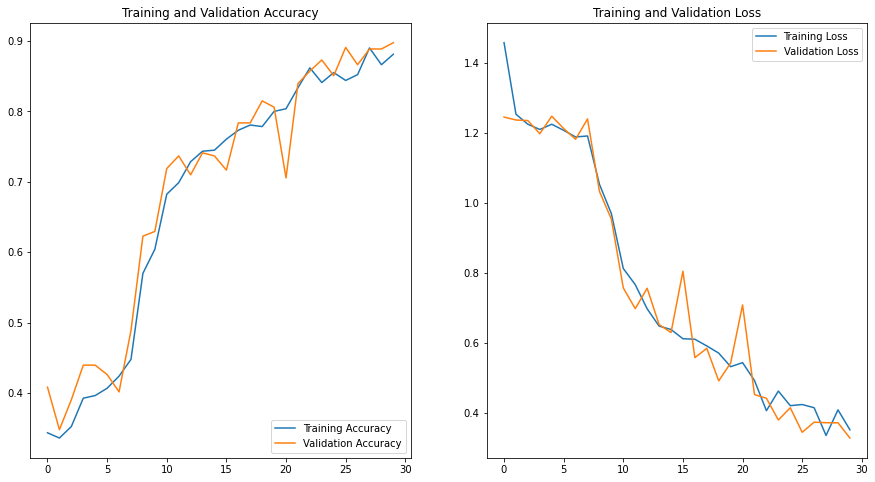

In [94]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
model2.save('saved_model/newModel.h5')

history = model2.fit(train_data, 
                              epochs=epochs,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[tensorboard_callback, stop])

Train for 42 steps, validate for 14 steps
Epoch 1/30
42/42 - 52s - loss: 0.3710 - categorical_accuracy: 0.8720 - val_loss: 0.3453 - val_categorical_accuracy: 0.8996
Epoch 2/30
42/42 - 28s - loss: 0.3576 - categorical_accuracy: 0.8884 - val_loss: 0.3806 - val_categorical_accuracy: 0.8750
Epoch 3/30
42/42 - 27s - loss: 0.3383 - categorical_accuracy: 0.8839 - val_loss: 0.3458 - val_categorical_accuracy: 0.8929
Epoch 4/30
42/42 - 29s - loss: 0.3431 - categorical_accuracy: 0.8854 - val_loss: 0.4071 - val_categorical_accuracy: 0.8594
Epoch 5/30
42/42 - 29s - loss: 0.3103 - categorical_accuracy: 0.8951 - val_loss: 0.2795 - val_categorical_accuracy: 0.9174
Epoch 6/30
42/42 - 28s - loss: 0.3131 - categorical_accuracy: 0.8921 - val_loss: 0.3110 - val_categorical_accuracy: 0.9085
Epoch 7/30
42/42 - 28s - loss: 0.3027 - categorical_accuracy: 0.9010 - val_loss: 0.3377 - val_categorical_accuracy: 0.8951
Epoch 8/30
42/42 - 28s - loss: 0.3196 - categorical_accuracy: 0.8914 - val_loss: 0.3116 - val_cat

In [ ]:
history = model2.fit(train_data, 
                              epochs=50,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[tensorboard_callback, stop])

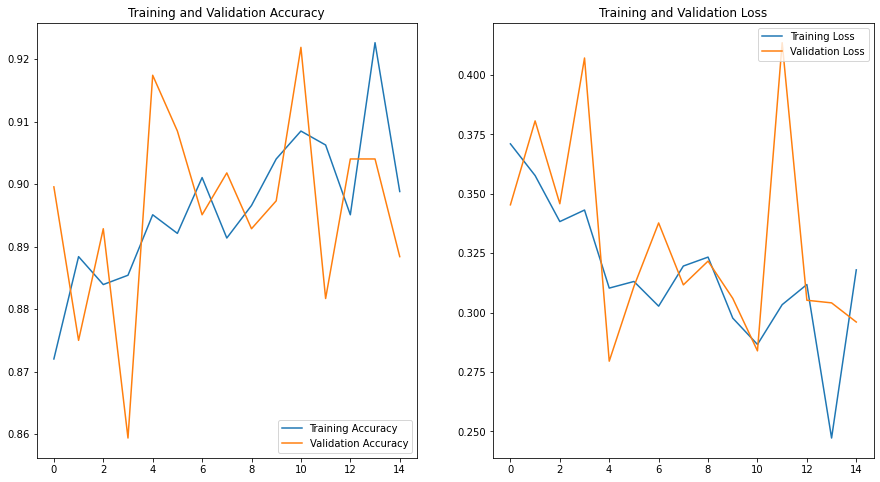

In [98]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
history = model2.fit(train_data, 
                              epochs=50,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[tensorboard_callback])

Train for 42 steps, validate for 14 steps
Epoch 1/50
42/42 - 53s - loss: 0.2988 - categorical_accuracy: 0.9062 - val_loss: 0.3173 - val_categorical_accuracy: 0.8862
Epoch 2/50
42/42 - 27s - loss: 0.2659 - categorical_accuracy: 0.9144 - val_loss: 0.3116 - val_categorical_accuracy: 0.8929
Epoch 3/50
42/42 - 27s - loss: 0.2916 - categorical_accuracy: 0.9055 - val_loss: 0.2722 - val_categorical_accuracy: 0.9107
Epoch 4/50
42/42 - 28s - loss: 0.2692 - categorical_accuracy: 0.9070 - val_loss: 0.3331 - val_categorical_accuracy: 0.8884
Epoch 5/50
42/42 - 27s - loss: 0.2775 - categorical_accuracy: 0.9025 - val_loss: 0.2919 - val_categorical_accuracy: 0.8996
Epoch 6/50
42/42 - 28s - loss: 0.2719 - categorical_accuracy: 0.9077 - val_loss: 0.3923 - val_categorical_accuracy: 0.8906
Epoch 7/50
42/42 - 27s - loss: 0.2699 - categorical_accuracy: 0.9070 - val_loss: 0.2686 - val_categorical_accuracy: 0.9129
Epoch 8/50
42/42 - 28s - loss: 0.2388 - categorical_accuracy: 0.9241 - val_loss: 0.3017 - val_cat

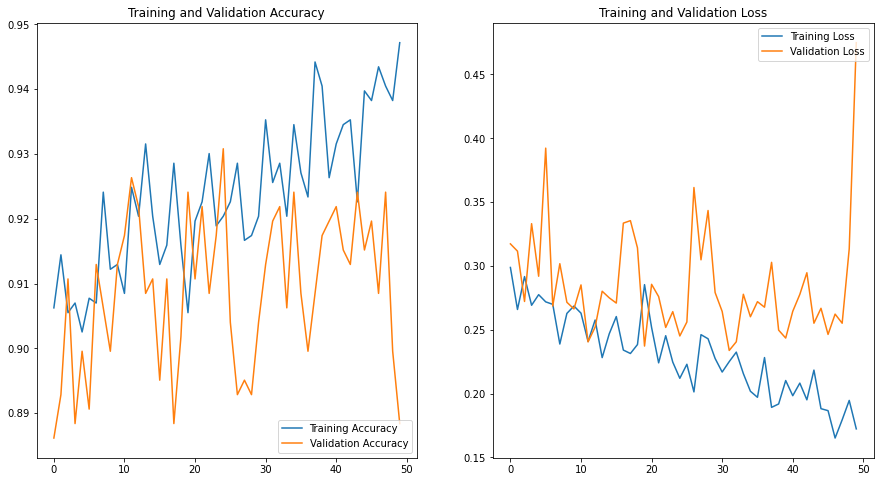

In [101]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history = model2.fit(train_data, 
                              epochs=50,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[tensorboard_callback])

Train for 42 steps, validate for 14 steps
Epoch 1/50
42/42 - 53s - loss: 0.1993 - categorical_accuracy: 0.9353 - val_loss: 0.2803 - val_categorical_accuracy: 0.8973
Epoch 2/50
42/42 - 29s - loss: 0.2119 - categorical_accuracy: 0.9323 - val_loss: 0.2464 - val_categorical_accuracy: 0.9241
Epoch 3/50
42/42 - 28s - loss: 0.1736 - categorical_accuracy: 0.9479 - val_loss: 0.3548 - val_categorical_accuracy: 0.9129
Epoch 4/50
42/42 - 30s - loss: 0.2080 - categorical_accuracy: 0.9323 - val_loss: 0.2129 - val_categorical_accuracy: 0.9353
Epoch 5/50
42/42 - 30s - loss: 0.1644 - categorical_accuracy: 0.9382 - val_loss: 0.2706 - val_categorical_accuracy: 0.9152
Epoch 6/50
42/42 - 30s - loss: 0.1740 - categorical_accuracy: 0.9315 - val_loss: 0.3130 - val_categorical_accuracy: 0.9085
Epoch 7/50
42/42 - 29s - loss: 0.1868 - categorical_accuracy: 0.9375 - val_loss: 0.3658 - val_categorical_accuracy: 0.8929
Epoch 8/50
42/42 - 29s - loss: 0.2085 - categorical_accuracy: 0.9375 - val_loss: 0.2587 - val_cat

In [37]:
epochs = 50


history3 = model3.fit(train_data, 
                              epochs=epochs,
                   validation_data=valid_data,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
             callbacks=[tensorboard_callback, stop])

Train for 42 steps, validate for 14 steps
Epoch 1/50
42/42 - 57s - loss: 2.7754 - categorical_accuracy: 0.3192 - val_loss: 1.2701 - val_categorical_accuracy: 0.3281
Epoch 2/50
42/42 - 44s - loss: 1.2395 - categorical_accuracy: 0.3452 - val_loss: 1.2493 - val_categorical_accuracy: 0.3728
Epoch 3/50
42/42 - 47s - loss: 1.2551 - categorical_accuracy: 0.3378 - val_loss: 1.2307 - val_categorical_accuracy: 0.3661
Epoch 4/50


KeyboardInterrupt: 

In [ ]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**BELOW ARE MODELS USING OLDER IMGAGEDATAGEN FLOW**

In [17]:
# create an augmented image generator 
# might be better to horizontally crop the images to square then resize down to 512x512
# or add canny edges detection to crop down the final images or something.  very differing background noise 
# some images have hands as background, other have sky, others have ground, others have other plants

batch = 32

imgH = 256
imgW = 256

image_generator_ = ImageDataGenerator(rescale=1./255, rotation_range=90, width_shift_range=0.05,
                                    height_shift_range=0.05, horizontal_flip=True, vertical_flip=True,zoom_range=0.05,
                                    featurewise_center=True, preprocessing_function=random_blurr)
val_image_gen_ = ImageDataGenerator(rescale=1./255, featurewise_center=True)
image_generator_.mean = [red_mean, green_mean, blue_mean]
val_image_gen_.mean = [red_mean, green_mean, blue_mean]

valGen_ = val_image_gen_.flow_from_dataframe(test_df,directory=None, x_col='path',
                                           y_col=['healthy','multiple_diseases','rust','scab'],
                                          batch_size=batch, class_mode='raw', target_size=(imgH,imgW))

traindataGen_ = image_generator_.flow_from_dataframe(train_df, directory=None, x_col='path', 
                                                   y_col=['healthy','multiple_diseases','rust','scab'],
                                                  target_size=(imgH,imgW), batch_size=batch, class_mode='raw')

stop = tf.keras.callbacks.EarlyStopping(patience=10)

Found 456 validated image filenames.
Found 1365 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1 0 0]


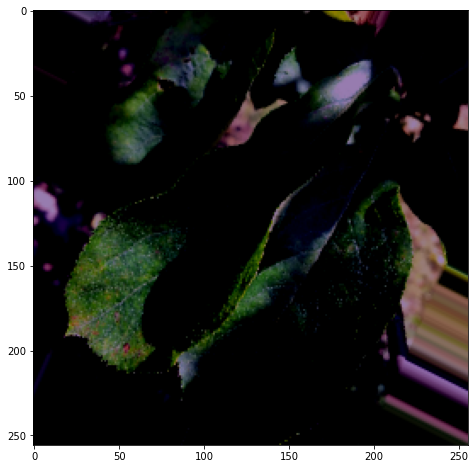

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


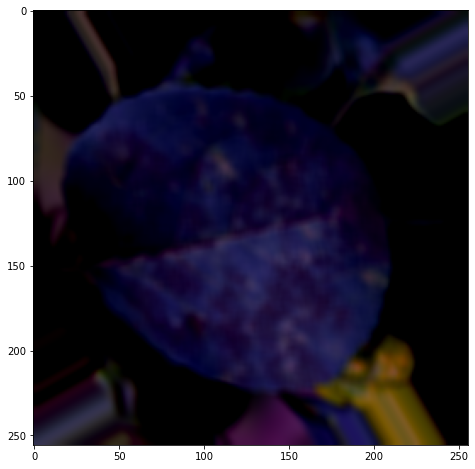

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


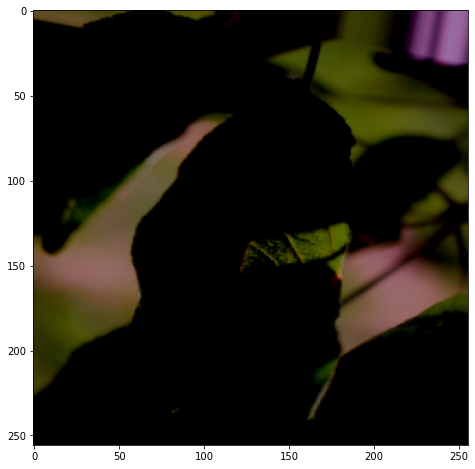

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


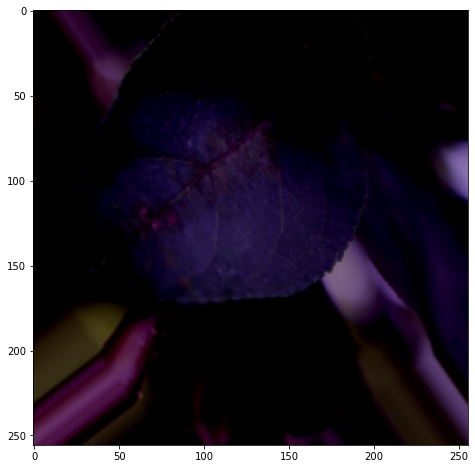

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


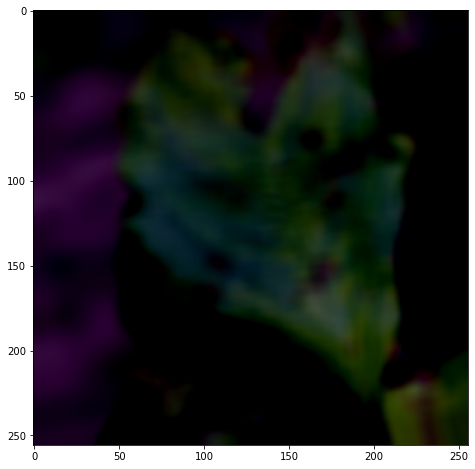

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 1]


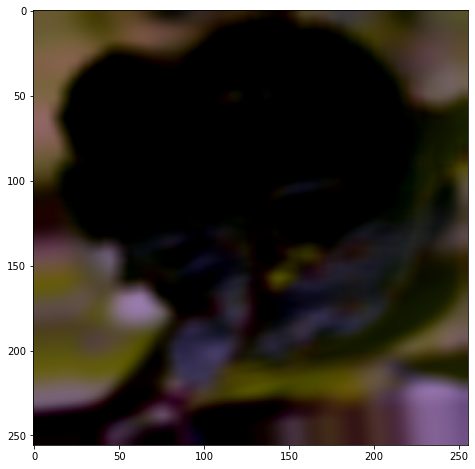

[0 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


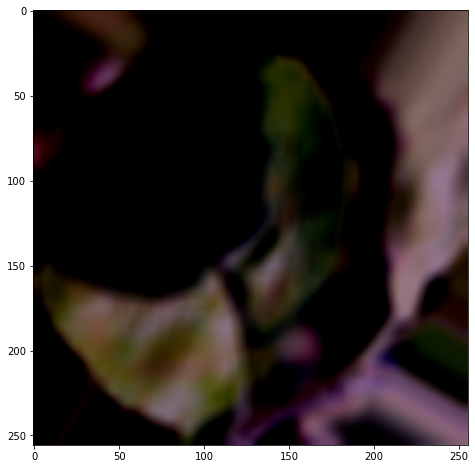

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 0 0 0]


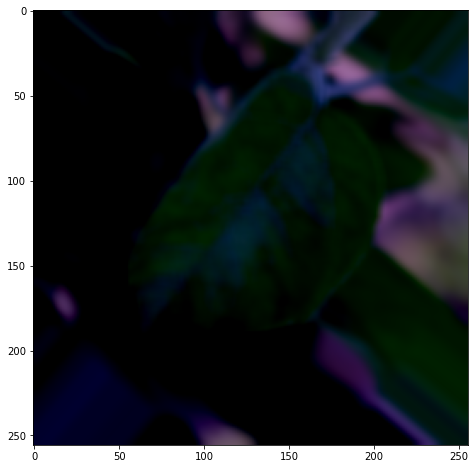

In [18]:
# visualize some of the augmented images 

counter = 0
for x, label in traindataGen_:
    
    if counter == 2:
        break
    print(label[1])
    plt.figure(figsize=(8,8))
    plt.imshow(x[1])
    plt.show()
    print(label[2])
    plt.figure(figsize=(8,8))
    plt.imshow(x[2])
    
    plt.show()
    print(label[3])
    plt.figure(figsize=(8,8))
    plt.imshow(x[3])
    plt.show()
    print(label[4])
    plt.figure(figsize=(8,8))
    plt.imshow(x[4])
    plt.show()
    counter += 1


**FOLLOWING COMMENTED OUT MODEL HAS BEEN TRAINED AND SAVED ALREADY - KEEPING IT HERE FOR REFERENCE - TRANSFER LEARN FROM IT LATER IN NOTEBOOK**

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(imgH, imgW,3), padding='valid',
                       data_format='channels_last'))
model2.add(layers.Conv2D(32, (3,3), activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model2.add(layers.Conv2D(128, (3,3), activation='relu', padding='same',dilation_rate=2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.1))


model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(y_train.shape[1], activation='softmax'))

model2.summary()





STEP_SIZE_TRAIN=traindataGen_.n//traindataGen_.batch_size
STEP_SIZE_VALID=valGen_.n//valGen_.batch_size


epochs = 75
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

history2 = model2.fit(traindataGen_, 
                              epochs=epochs,
                   validation_data=valGen_,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2,
                     callbacks=[stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0

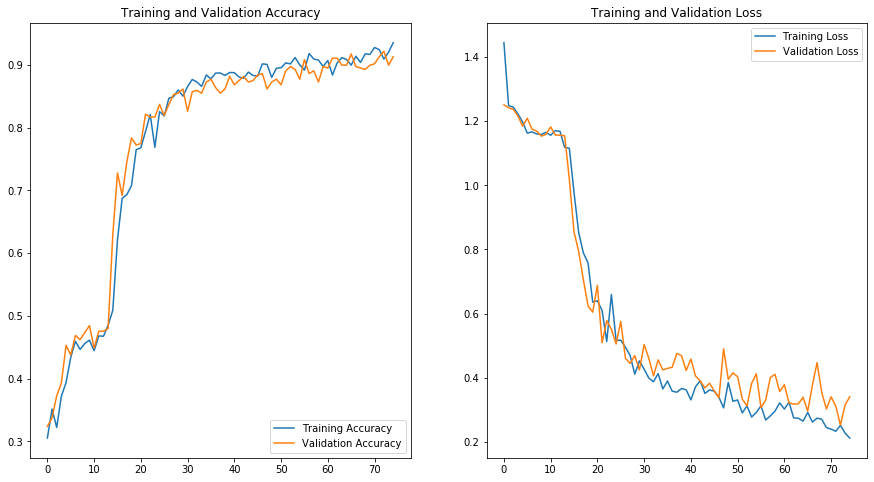

In [15]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
label_array = labels.columns[1::]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


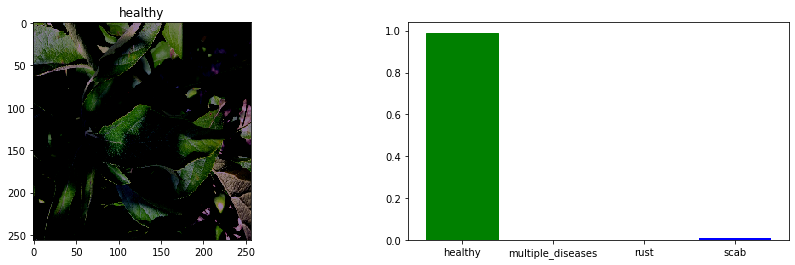

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


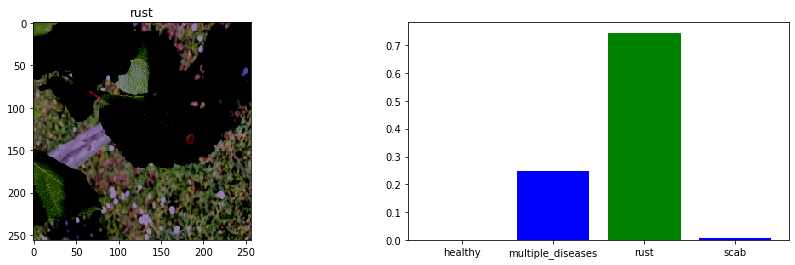

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


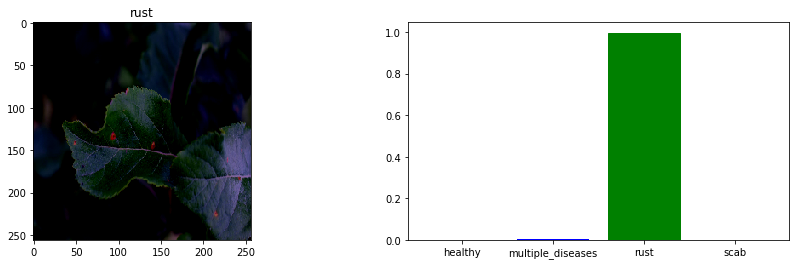

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


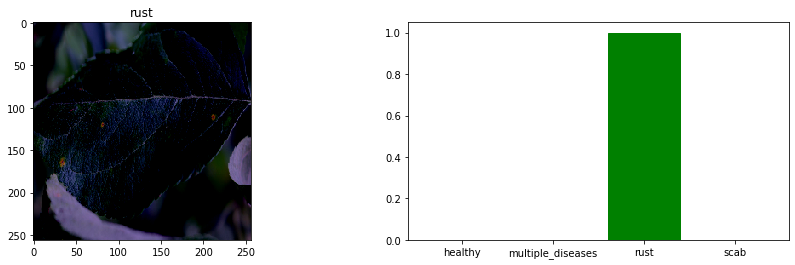

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


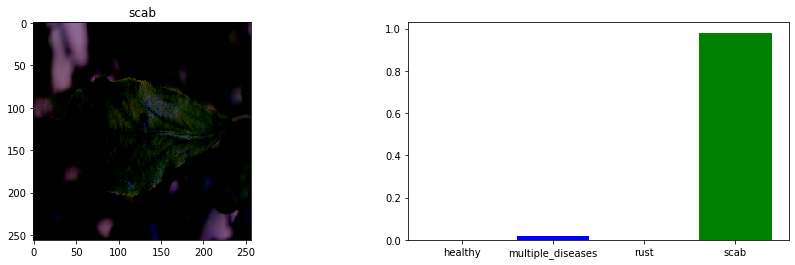

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


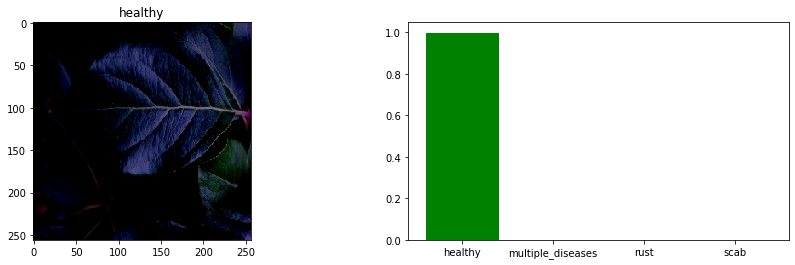

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


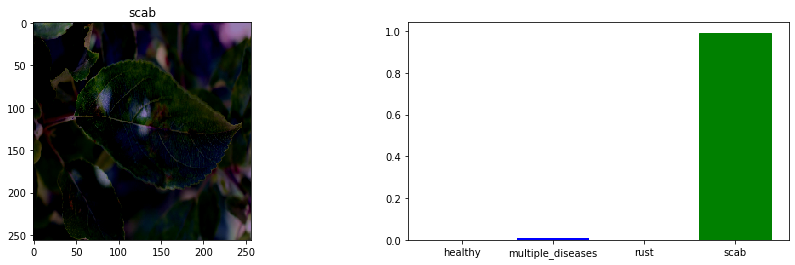

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


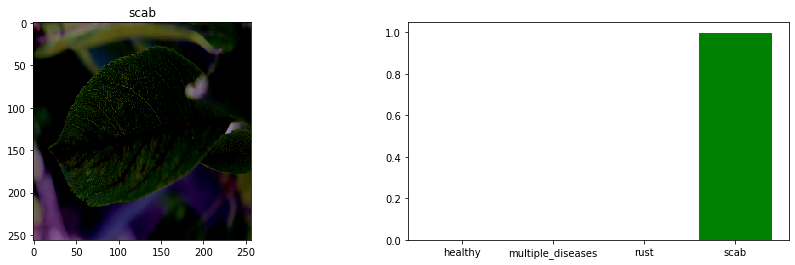

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


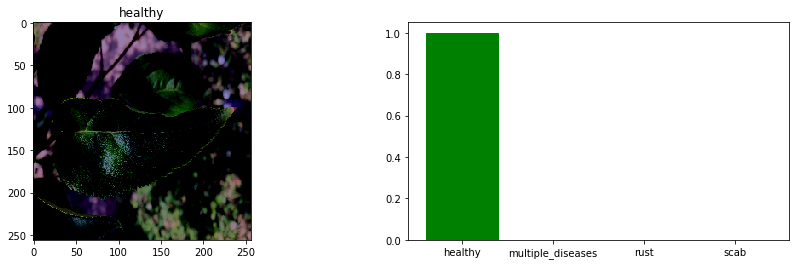

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


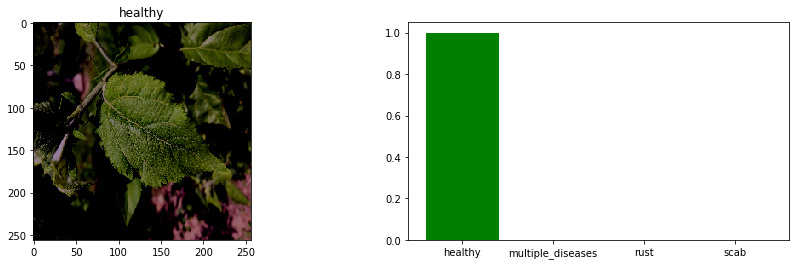

In [17]:
label_array = labels.columns[1::]
# plot_imgs = val_images.copy()
tru_labels = y_test.values
counter = 0
for i, label in valGen_:
    if counter <= 9:
        # index = np.random.randint(low=0, high=len(plot_imgs), size=1)
        # img_predicted_on = plot_imgs[index][0]
        # full_img_path = test_df.path.values[index]
        # full_img_path = full_img_path[0].split('.')[0] + '.jpg'
        # img = cv2.imread(full_img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pred_array = model2.predict(i)
        pred_class = label_array[np.argmax(pred_array[0])]
        
        tru_class = label_array[np.argmax(label)]
    #     if tru_class in ['healthy','rust']:
    #         continue
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        if pred_class == tru_class:
            pred_color = 'g'
            tru_color = 'g'
        else:
            pred_color = 'r'
            tru_color = 'g'
            
        ax[0].imshow(i[0])
        ax[0].set_title('{}'.format(tru_class))
        bar = ax[1].bar(label_array, pred_array[0], color='b')
        bar[np.argmax(pred_array[0])].set_color(pred_color)
        bar[np.argmax(label)].set_color(tru_color)
        counter += 1
        plt.show()
    else:
      break

# counter = 0
# for i, label in valGen_:
#   if counter <= 9:
#     print(i[0].shape)
#     counter +=1 
#   else:
#     break

In [ ]:
import seaborn as sns
# confustion = tf.math.confusion_matrix(tru_labels, predictions, num_classes=4)
# plt.figure(figsize=(15,15))
# sns.heatmap(confusion, annot=True)

In [18]:
model2.save('saved_model/newestModel_local')

In [ ]:
%ls


**STARTING ANOTHER MODEL FROM HERE, Transfer learning from above model to one with more augemnted and larger images**  

In [13]:
prior = tf.keras.models.load_model('saved_model/newestModel_local')
prior.summary()
for layer in prior.layers:
    print(layer)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
________________________________

In [14]:
batch = 32

imgH = 512
imgW = 512

image_generator_ = ImageDataGenerator(rescale=1./255, rotation_range=90, width_shift_range=0.05,
                                    height_shift_range=0.05, horizontal_flip=True, vertical_flip=True,zoom_range=0.05,
                                    featurewise_center=True, preprocessing_function=random_blurr)
val_image_gen_ = ImageDataGenerator(rescale=1./255, featurewise_center=True)
image_generator_.mean = [red_mean, blue_mean, green_mean]
val_image_gen_.mean = [red_mean, blue_mean, green_mean]

valGen_ = val_image_gen_.flow_from_dataframe(test_df,directory=None, x_col='path',
                                           y_col=['healthy','multiple_diseases','rust','scab'],
                                          batch_size=batch, class_mode='raw', target_size=(imgH,imgW))

traindataGen_ = image_generator_.flow_from_dataframe(train_df, directory=None, x_col='path', 
                                                   y_col=['healthy','multiple_diseases','rust','scab'],
                                                  target_size=(imgH,imgW), batch_size=batch, class_mode='raw')

Found 456 validated image filenames.
Found 1365 validated image filenames.


In [15]:
model3 = models.Sequential()

model3.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(imgH, imgW,3), padding='valid',
                       data_format='channels_last', name='Conv_New'))
model3.add(layers.MaxPool2D(name='NewPool'))
model3.add(layers.Dropout(0.15, name='NewDrop'))

for layer in prior.layers[1:-2]:
    model3.add(layer)




model3.add(layers.Dense(512,activation='relu'))
model3.add(layers.Dropout(0.15, name='Dropout_new'))
model3.add(layers.Dense(y_train.shape[1], activation='softmax'))



STEP_SIZE_TRAIN=traindataGen_.n//traindataGen_.batch_size
STEP_SIZE_VALID=valGen_.n//valGen_.batch_size


epochs = 30



# want to initialize the weights with pre-trained layers - want them to still train though, not using this one 
# for layer in model3.layers[3:-3]:
#     layer.trainable = False

for layer in model3.layers:
    print(layer)
    print(layer.trainable)


    
model3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
    
model3.summary()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_New (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
NewPool (MaxPooling2D)       (None, 255, 255, 32)      0         
_________________________________________________________________
NewDrop (Dropout)            (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
________________________________

In [16]:
history3 = model3.fit(traindataGen_, 
                              epochs=75,
                   validation_data=valGen_,steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID, verbose=2)

Epoch 1/75
42/42 - 95s - loss: 1.3019 - categorical_accuracy: 0.3451 - val_loss: 1.2064 - val_categorical_accuracy: 0.3929
Epoch 2/75
42/42 - 94s - loss: 1.1978 - categorical_accuracy: 0.4278 - val_loss: 1.1511 - val_categorical_accuracy: 0.4888
Epoch 3/75
42/42 - 92s - loss: 0.8209 - categorical_accuracy: 0.7141 - val_loss: 0.6406 - val_categorical_accuracy: 0.7879
Epoch 4/75
42/42 - 90s - loss: 0.5232 - categorical_accuracy: 0.8312 - val_loss: 0.3730 - val_categorical_accuracy: 0.8906
Epoch 5/75
42/42 - 88s - loss: 0.4005 - categorical_accuracy: 0.8710 - val_loss: 0.4285 - val_categorical_accuracy: 0.8571
Epoch 6/75
42/42 - 87s - loss: 0.4214 - categorical_accuracy: 0.8690 - val_loss: 0.4895 - val_categorical_accuracy: 0.8616
Epoch 7/75
42/42 - 85s - loss: 0.3672 - categorical_accuracy: 0.8850 - val_loss: 0.3574 - val_categorical_accuracy: 0.8862
Epoch 8/75
42/42 - 84s - loss: 0.3235 - categorical_accuracy: 0.9085 - val_loss: 0.2947 - val_categorical_accuracy: 0.9040
Epoch 9/75
42/42

KeyboardInterrupt: 

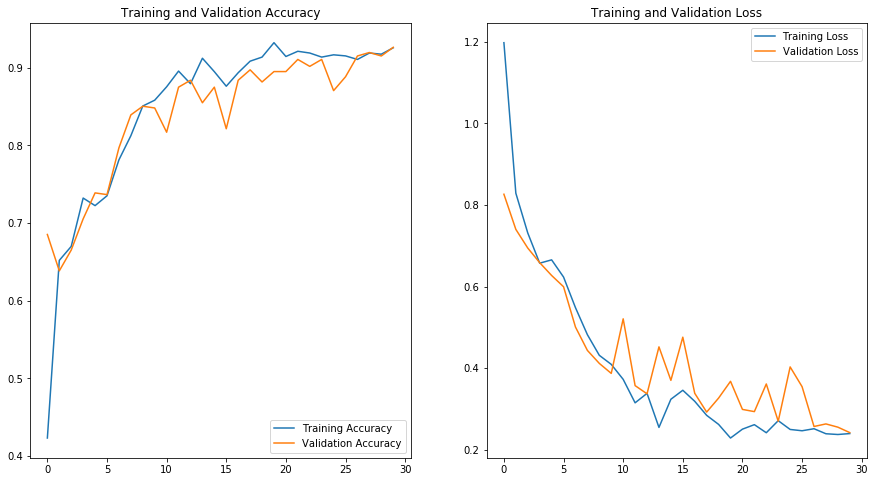

In [20]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs = 30
epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.5750024e-03 1.5511249e-02 1.5421547e-05 9.8289824e-01]]


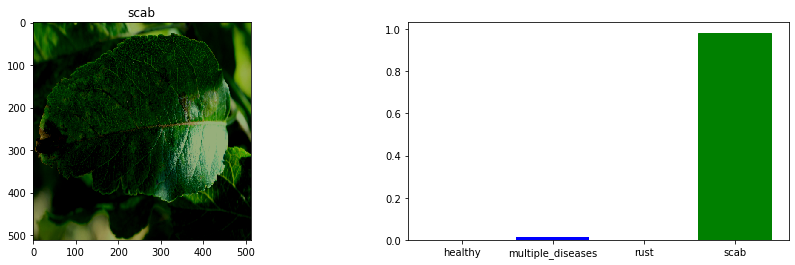

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[9.6281856e-06 8.5388161e-02 9.1459972e-01 2.5213653e-06]]


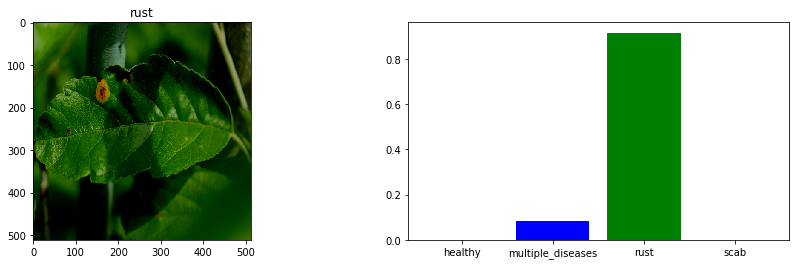

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[2.367664e-22 7.693988e-05 9.999231e-01 5.378915e-23]]


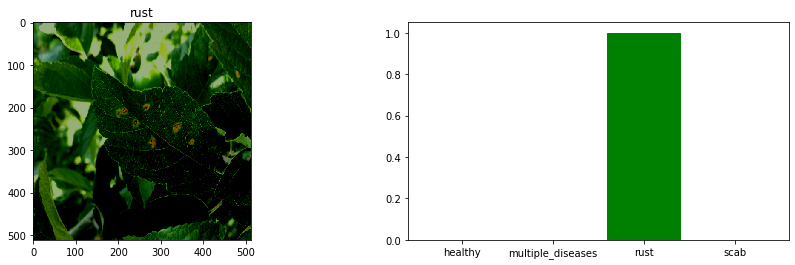

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[2.2253217e-04 1.8099090e-02 9.0281625e-05 9.8158801e-01]]


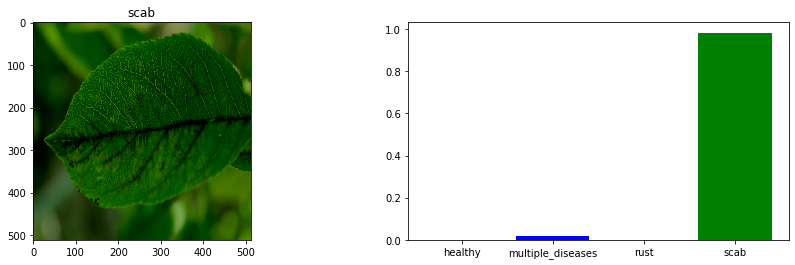

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.4931027e-08 8.5684955e-03 9.9143147e-01 3.5255490e-09]]


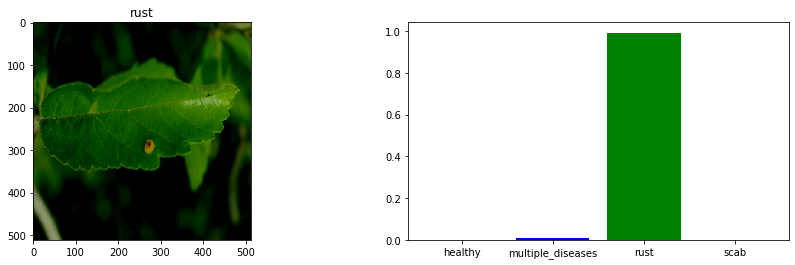

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[4.3426982e-21 8.4961066e-04 9.9915040e-01 8.8259622e-21]]


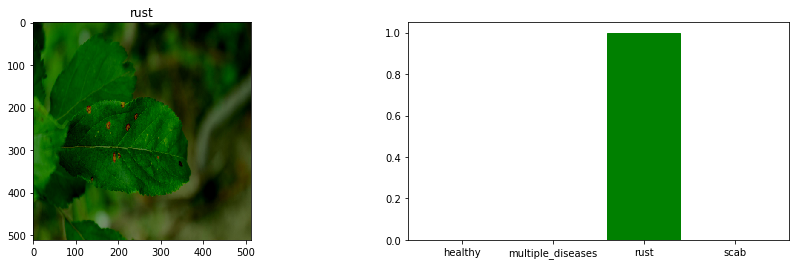

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[8.700083e-11 6.406665e-03 9.935933e-01 7.391308e-13]]


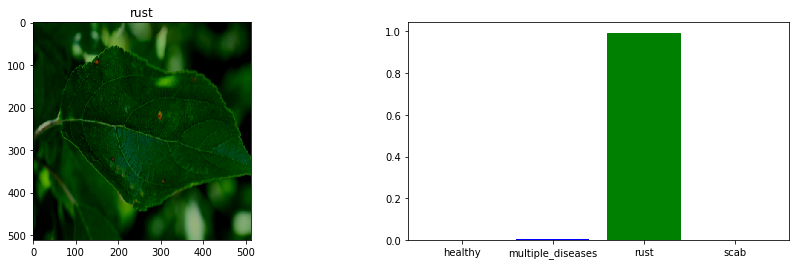

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[7.1883376e-05 1.3832104e-01 7.2731386e-04 8.6087978e-01]]


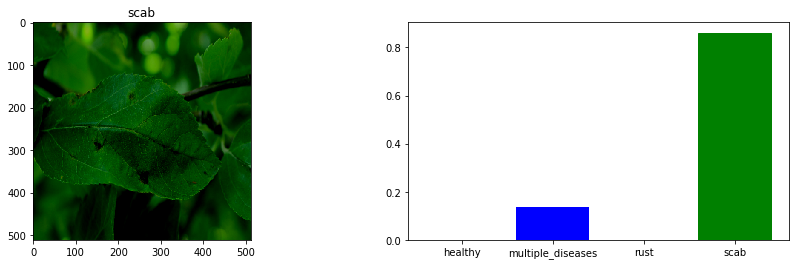

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.10376097 0.14267066 0.00397544 0.7495929 ]]


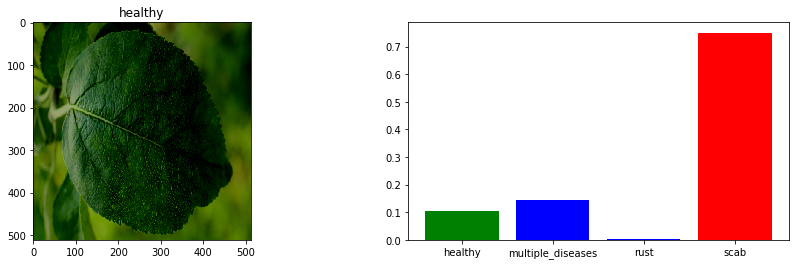

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00161095 0.7415339  0.02701353 0.2298416 ]]


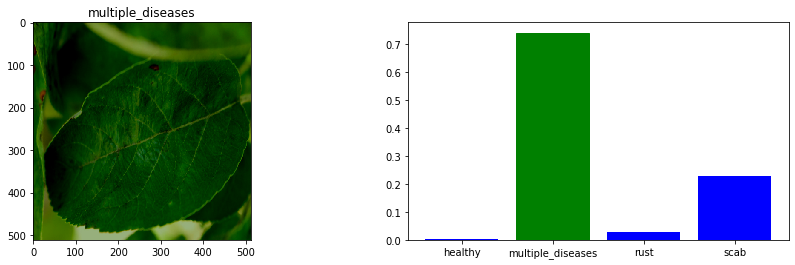

In [21]:
label_array = labels.columns[1::]
# plot_imgs = val_images.copy()
tru_labels = y_test.values
counter = 0
for i, label in valGen_:
    if counter <= 9:
        # index = np.random.randint(low=0, high=len(plot_imgs), size=1)
        # img_predicted_on = plot_imgs[index][0]
        # full_img_path = test_df.path.values[index]
        # full_img_path = full_img_path[0].split('.')[0] + '.jpg'
        # img = cv2.imread(full_img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(i[0], axis=0)
        pred_array = model3.predict(img)
        print(pred_array)
        pred_class = label_array[np.argmax(pred_array)]
        
        tru_class = label_array[np.argmax(label[0])]
    #     if tru_class in ['healthy','rust']:
    #         continue
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        if pred_class == tru_class:
            pred_color = 'g'
            tru_color = 'g'
        else:
            pred_color = 'r'
            tru_color = 'g'
            
        ax[0].imshow(i[0])
        ax[0].set_title('{}'.format(tru_class))
        bar = ax[1].bar(label_array, pred_array[0], color='b')
        bar[np.argmax(pred_array[0])].set_color(pred_color)
        bar[np.argmax(label)].set_color(tru_color)
        counter += 1
        # plt.show()

        plt.show()
    else:
      break

# counter = 0
# for i, label in valGen_:
#   if counter <= 9:
#     print(i[0].shape)
#     counter +=1 
#   else:
#     break

In [ ]:
test_df = pd.read_csv('test.csv')
test_df['path'] = test_df.image_id.progress_apply(create_paths)
test_df.path.values[:5]

In [ ]:
for i,d in enumerate(test_df.path.values[:25]):
    img = cv2.imread(d)
    img = cv2.resize(img, (512,512))
    img = img / 255
#     img = channel_norm(img).astype('float32') 
    img = np.array(img)
    img[:,:,0] -= blue_mean 
    img[:,:,1] -= green_mean 
    
    img[:,:,2] -= red_mean 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pred = np.expand_dims(img, 0)
    pred = model3.predict(img_pred)
    pred = label_array[np.argmax(pred)]
    if pred == 'rust':
        continue
    plt.imshow(img)
    plt.show()

    print('='*25,pred,'='*25)
    full_im = cv2.imread(d)
    full_im = cv2.cvtColor(full_im, cv2.COLOR_BGR2RGB)
    plt.imshow(full_im)
    plt.show()

